In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.svm import SVC
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from skfeature.function.similarity_based.fisher_score import fisher_score, feature_ranking
import warnings
from metrics import *
warnings.filterwarnings("ignore")
plt.style.use('seaborn-whitegrid')

<br>

In [2]:
texturas = pd.read_excel('BBDD_caEnd_articulo_jmCarot.xlsx', usecols='DG:FKW')
grado = pd.read_excel('BBDD_caEnd_articulo_jmCarot.xlsx', usecols='AT')

na_ind = [47, 91, 94, 97]
texturas = texturas.drop(na_ind)
grado = grado.drop(na_ind)

grado_dico = grado.replace({1:0, 2:1, 3:1})

In [3]:
X_texturas = texturas.values
scaler = StandardScaler()
X_texturas_scaled = scaler.fit_transform(X_texturas)
Y = grado_dico.values.T[0] 

<br>

In [4]:
def confidence_intervals_for_each_fisher_threshold(f, L, X_texturas_scaled, Y, model, thresholds = 250, experiments = 20):
    
    def thresholds_search(f, L, X, number_thresholds = 320):
        percentil = 99
        while True:
            if X[:,f[L[f] > np.percentile(L, percentil)]].shape[1] >= 160:
                break
            percentil -= 0.2
        obs_ini = 1
        while True:
            if X[:,f[L[f] > L[f][obs_ini]]].shape[1] > 0:
                break
            obs_ini += 1
        return np.linspace(L[f][obs_ini], np.percentile(L, percentil), number_thresholds)
    
    random_states = set(np.random.random_integers(3000, size = (1, experiments))[0])
    results = {}
    n_vbles_last = 79999
    fisher_thresholds = thresholds_search(f, L, X_texturas_scaled, number_thresholds = thresholds)
    best_auc_fisher_threshold = (0, 0, 0) #auc, lap.threshold, random state
    for i in fisher_thresholds:
        # Variables con un valor de Fisher Score mayor que el threshold
        X_texturas_selected = X_texturas_scaled[:,f[L[f] > i]]
        aucs = []
        accs = []
        # Si con el threshold obtenemos el mismo número de variables que antes, nos lo saltamos
        if X_texturas_selected.shape[1] == n_vbles_last:
            pass
        auc_max_rand_state = (0, 0)
        for rand_state in random_states:
            kf = StratifiedKFold(n_splits=10, shuffle = True, random_state = rand_state)
            probas = np.zeros((X_texturas_selected.shape[0],2))
            accs_aux_cv = []
            for train_index, test_index in kf.split(X_texturas_selected, Y):
                X_train, X_test = X_texturas_selected[train_index], X_texturas_selected[test_index]
                y_train, y_test = Y[train_index], Y[test_index]
                dt = model
                probas_ = dt.fit(X_train, y_train).predict_proba(X_test)
                accs_aux_cv.append(dt.score(X_test, y_test))
                probas[test_index, :] = probas_
            
            fpr, tpr, thresholds_for_roc = roc_curve(Y, probas[:, 1])
            acc = np.array(accs_aux_cv).mean()
            roc_auc = auc(fpr, tpr)
            if roc_auc > auc_max_rand_state[0]:
                auc_max_rand_state = (roc_auc, rand_state)
            aucs.append(roc_auc)
            accs.append(acc)
        
        aucs = np.array(aucs)
        accs = np.array(accs)
        auc_mean, accs_mean = aucs.mean(), accs.mean()
        auc_std, accs_std = aucs.std(), accs.std()
        auc_max, accs_max = max(aucs), max(accs)
        auc_min, accs_min = min(aucs), min(accs)
        if auc_mean > best_auc_fisher_threshold[0]:
            best_auc_fisher_threshold = (auc_mean, i, auc_max_rand_state[1] )
        n_vbles = X_texturas_selected.shape[1]
        n_vbles_last = n_vbles
        results[i] = [(auc_mean, auc_std, auc_max, auc_min, n_vbles), 
                      (accs_mean, accs_std, accs_max, accs_min, n_vbles)
                     ]
    return results, best_auc_fisher_threshold

In [5]:
def thresholds_search(f, L, X, number_thresholds = 320):
    percentil = 99
    while True:
        if X[:,f[L[f] > np.percentile(L, percentil)]].shape[1] >= 160:
            break
        percentil -= 0.2
    obs_ini = 1
    while True:
        if X[:,f[L[f] > L[f][obs_ini]]].shape[1] > 0:
            break
        obs_ini += 1
    return np.linspace(L[f][obs_ini], np.percentile(L, percentil), number_thresholds)

In [6]:
def get_cross_validation_threshold(X_texturas_scaled, Y, f, L, fisher_thresholds, dt, random_state = 344):
    results = {}
    for i in fisher_thresholds:
        X_texturas_selected = X_texturas_scaled[:,f[L[f] > i]]

        kf = StratifiedKFold(n_splits=10, shuffle = True, random_state = random_state)
        probas = np.zeros((X_texturas_selected.shape[0],2))
        for train_index, test_index in kf.split(X_texturas_selected, Y):
            X_train, X_test = X_texturas_selected[train_index], X_texturas_selected[test_index]
            y_train, y_test = Y[train_index], Y[test_index]
            probas_ = dt.fit(X_train, y_train).predict_proba(X_test)
            probas[test_index, :] = probas_
        fpr, tpr, _ = roc_curve(Y, probas[:, 1])
        roc_auc = auc(fpr, tpr)
        results[i] = roc_auc
    return results

## SVM kernel = linear -- Fisher Score

In [7]:
L = fisher_score(X_texturas_scaled, Y)
f = feature_ranking(L)
fisher_thresholds = thresholds_search(f, L, X_texturas_scaled, number_thresholds = 20)

In [8]:
model = SVC(probability = True, kernel = 'linear', random_state = 3)
results, best_auc_fisher_threshold = confidence_intervals_for_each_fisher_threshold(
                                                            f, L, 
                                                            X_texturas_scaled, 
                                                            Y, 
                                                            model, 
                                                            thresholds = 100, 
                                                            experiments = 20)

In [9]:
auc_mean, auc_std, auc_max, auc_min, c, n_vbles = max([(mean_, std_, max_, min_, c, n_vbles) for c, [(mean_, std_, max_, min_, n_vbles),_] in results.items()])
print('[INFO] Best threshold: {}'.format(c))
print('AUC mean: {}'.format(auc_mean))
print('AUC std: {}'.format(auc_std))
print('AUC max: {}'.format(auc_max))
print('AUC min: {}'.format(auc_min))
print('AUC medio: {} Máximo AUC: {}  con un random state de {} y un fisher threshold de {}'.format(best_auc_fisher_threshold[0], 
                                                                                                      auc_max,
                                                                                                      best_auc_fisher_threshold[2],
                                                                                                      best_auc_fisher_threshold[1]))

[INFO] Best threshold: 0.026269699911091224
AUC mean: 0.6966559449866904
AUC std: 0.019761503487143138
AUC max: 0.75
AUC min: 0.6530612244897959
AUC medio: 0.6966559449866904 Máximo AUC: 0.75  con un random state de 133 y un fisher threshold de 0.026269699911091224


In [10]:
acc_mean, acc_std, acc_max, acc_min, c, n_vbles = max([(mean_, std_, max_, min_, c, n_vbles) for c, [_,(mean_, std_, max_, min_, n_vbles)] in results.items()])
print('[INFO] Best threshold: {}'.format(c))
print('Accuracy mean: {}'.format(acc_mean))
print('Accuracy std: {}'.format(acc_std))
print('Accuracy max: {}'.format(acc_max))
print('Accuracy min: {}'.format(acc_min))

[INFO] Best threshold: 0.04839959425074449
Accuracy mean: 0.7215714285714285
Accuracy std: 0.007616219713288755
Accuracy max: 0.7361904761904761
Accuracy min: 0.7019047619047619


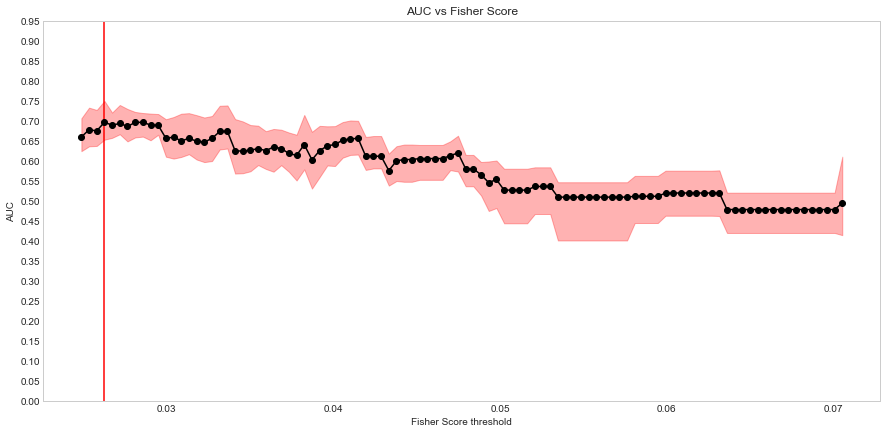

In [11]:
fig = plt.figure(figsize=(15,7))
plt.axvline(x = max([(auc_mean, c) for c, [(auc_mean, auc_std, auc_max, auc_min, n_vbles),_] in results.items()])[1], color = 'r')
plt.plot(results.keys(), [i[0][0] for i in results.values()], '-ok')
plt.fill_between(results.keys(),[i[0][3] for i in results.values()],[i[0][2] for i in results.values()], alpha=0.3, edgecolor='red', facecolor='red')
plt.grid(False)
plt.yticks(np.arange(0, 1, step=0.05))
#plt.xticks(np.arange(min(fisher_thresholds), max(fisher_thresholds), step = 0.01))
plt.title('AUC vs Fisher Score')
plt.xlabel('Fisher Score threshold')
plt.ylabel('AUC')
plt.show()

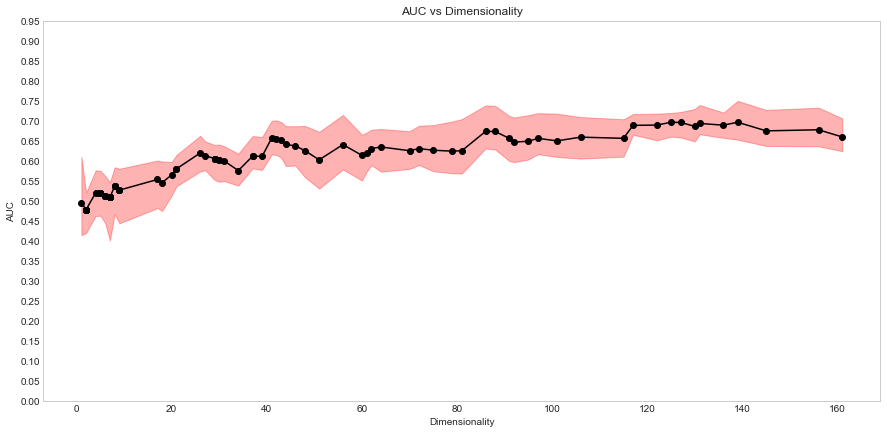

In [12]:
fig = plt.figure(figsize=(15,7))
n_vbles_x = [i[0][4] for i in results.values()]
aucs_y = [i[0][0] for i in results.values()]
plt.plot(n_vbles_x, aucs_y, '-ok')
plt.fill_between(n_vbles_x,[i[0][3] for i in results.values()],[i[0][2] for i in results.values()], alpha=0.3, edgecolor='red', facecolor='red')
plt.grid(False)
plt.yticks(np.arange(0, 1, step=0.05))
plt.title('AUC vs Dimensionality')
plt.xlabel('Dimensionality')
plt.ylabel('AUC')
plt.show()

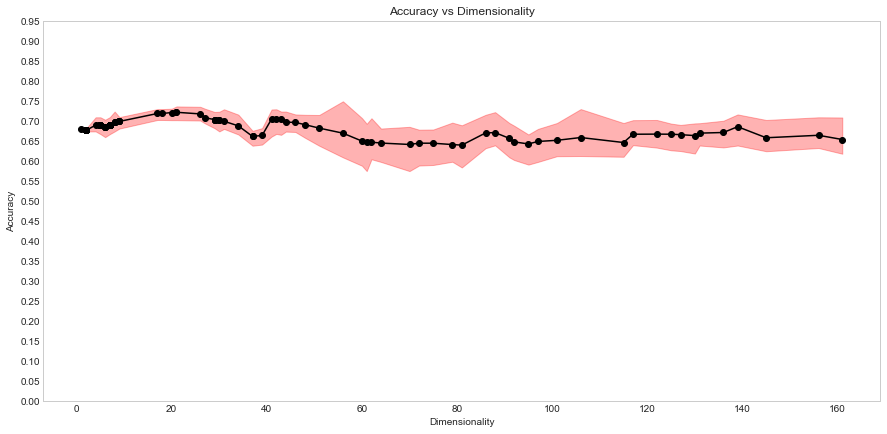

In [13]:
fig = plt.figure(figsize=(15,7))
n_vbles_x = [i[1][4] for i in results.values()]
accs_y = [i[1][0] for i in results.values()]
plt.plot(n_vbles_x, accs_y, '-ok')
plt.fill_between(n_vbles_x,[i[1][3] for i in results.values()],[i[1][2] for i in results.values()], alpha=0.3, edgecolor='red', facecolor='red')
plt.grid(False)
plt.yticks(np.arange(0, 1, step=0.05))
plt.title('Accuracy vs Dimensionality')
plt.xlabel('Dimensionality')
plt.ylabel('Accuracy')
plt.show()

In [16]:
df_fisher_svm = pd.DataFrame({'Threshold': list(results.keys()),
                                 'Dimensionality': [i[0][4] for i in results.values()], 
                                 'AUC_Mean':[i[0][0] for i in results.values()], 
                                 'AUC_Std': [i[0][1] for i in results.values()],
                                 'AUC_Min': [i[0][3] for i in results.values()], 
                                 'AUC_Max': [i[0][2] for i in results.values()], 
                                 
                                 'acc_Mean':[i[1][0] for i in results.values()], 
                                 'acc_Std': [i[1][1] for i in results.values()],
                                 'acc_Min': [i[1][3] for i in results.values()], 
                                 'acc_Max': [i[1][2] for i in results.values()]
                                 
                                 })

In [17]:
df_fisher_svm.to_excel('df_fisher_svm.xlsx', index = False)

## Mejor modelo

El que obtiene el máximo AUC para el mejor threshold de Fisher Score

In [14]:
rand_state_best = best_auc_fisher_threshold[2]
threshold_best = best_auc_fisher_threshold[1]
X_texturas_selected = X_texturas_scaled[:,f[L[f] > threshold_best]]

kf = StratifiedKFold(n_splits=10, shuffle = True, random_state = rand_state_best)
probas = np.zeros((X_texturas_selected.shape[0],2))
for train_index, test_index in kf.split(X_texturas_selected, Y):
    X_train, X_test = X_texturas_selected[train_index], X_texturas_selected[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    dt = SVC(probability = True, kernel = 'linear', random_state = 3)
    probas_ = dt.fit(X_train, y_train).predict_proba(X_test)
    probas[test_index, :] = probas_

In [19]:
probs_df = pd.DataFrame(probas)
probs_df['Y'] = Y
probs_df.to_excel('Predictions_Fisher_Score_SVM.xlsx')

## Intervalos confianza con más pruebas para el fisher threshold

In [15]:
X_texturas_selected = X_texturas_scaled[:,f[L[f] > threshold_best]] 

random_states = set(np.random.random_integers(3000, size = (1, 200))[0]) # 200 experimentos

results_remuestreo = {'AUC': [], 'Accuracy':[]}
for rand_state in random_states:
    kf = StratifiedKFold(n_splits=10, shuffle = True, random_state = rand_state)
    probas = np.zeros((X_texturas_selected.shape[0],2))
    acc_cv = []
    for train_index, test_index in kf.split(X_texturas_selected, Y):
        X_train, X_test = X_texturas_selected[train_index], X_texturas_selected[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        dt = SVC(probability = True, kernel = 'linear', random_state = 3)
        probas_ = dt.fit(X_train, y_train).predict_proba(X_test)
        acc_cv.append(dt.score(X_test, y_test))
        probas[test_index, :] = probas_
    acc = np.array(acc_cv).mean()
    fpr, tpr, thresholds_for_roc = roc_curve(Y, probas[:, 1])
    roc_auc = auc(fpr, tpr)
    results_remuestreo['AUC'].append(roc_auc)
    results_remuestreo['Accuracy'].append(acc)

In [17]:
media_auc = np.array(results_remuestreo['AUC']).mean()
std_auc = np.array(results_remuestreo['AUC']).std()
media_acc = np.array(results_remuestreo['Accuracy']).mean()
std_acc = np.array(results_remuestreo['Accuracy']).std()

print_value = lambda n, mean, std: print('{}: mean: {} - std: {}'.format(n, mean, std))
print_value('AUC', media_auc, std_auc)
print_value('Accuracy', media_acc, std_acc)

AUC: mean: 0.6977360114006076 - std: 0.025052424951629144
Accuracy: mean: 0.6859908609908608 - std: 0.02092876054656421
